# Chicago Beach Data in Python

There are 27 public beaches in Chicago, along 26 miles of the city's lakefront shoreline, managed by the Chicago Park District.
<br> Here are the beach locations:
![Chicago Beach Locations](https://github.com/agnesbao/chicagobeach/blob/master/Ecoli_test_locations.png?raw=true)

The city of Chicago provides the public with beach weather and beach water quality data hour by hour from several sensors during the summer. The data is available at https://data.cityofchicago.org/Parks-Recreation/Beach-Water-Quality-Automated-Sensors/qmqz-2xku. 
<br> Here are the locations of the water and weather sensors:
![](https://github.com/agnesbao/chicagobeach/blob/master/sensor_locations.png?raw=true)

We will look at the beach water data first.
Using the website's API, we can grab a maximum of 50000 data points:

In [27]:
# import package
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import sklearn.linear_model
from fbprophet import Prophet

In [3]:
def request_data(url):
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
    return pd.DataFrame(data)

water_url = "https://data.cityofchicago.org/resource/46rk-hgnz.json?$limit=50000"
water_df = request_data(water_url)
water_df.columns

Index(['battery_life', 'beach_name', 'measurement_id', 'measurement_timestamp',
       'measurement_timestamp_label', 'transducer_depth', 'turbidity',
       'water_temperature', 'wave_height', 'wave_period'],
      dtype='object')

The water sensor measures: Turbidity, which is the key measurement of water quality, higher number means the water is more cloudy. Besides, there is water temperature, wave height and wave period. We will focus on the turbidity for now. 
<br> The data starts from the end of August 2013. 
<br> First, let's look at which sensors are giving out readings each year.

In [4]:
water_df.index=pd.to_datetime(water_df.measurement_timestamp)
water_df = water_df.sort_index()
water_df = water_df.dropna(subset=['measurement_timestamp'])
for yr in range(2014,pd.to_datetime('today').year+1):
    print(str(yr)+': ')
    print(water_df.beach_name[water_df.index.year==yr].unique())

2014: 
['Rainbow Beach' 'Calumet Beach' 'Montrose Beach' 'Ohio Street Beach'
 '63rd Street Beach' 'Osterman Beach']
2015: 
['Rainbow Beach' 'Ohio Street Beach' '63rd Street Beach' 'Calumet Beach'
 'Montrose Beach' 'Osterman Beach']
2016: 
['Ohio Street Beach' 'Montrose Beach' 'Calumet Beach']
2017: 
['Ohio Street Beach']


Oh no, looks like the sensors are dying off. Only the one at Ohio Street Beach is still alive this year.
<br>Let's look at the turbidity record as of today:

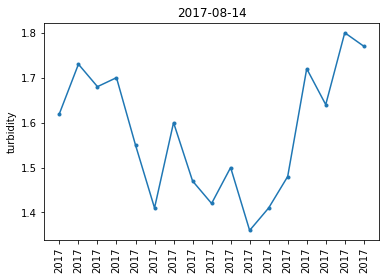

In [8]:
def log_transform(num):
    if num>0:
        num = np.log(num)
    return num

def plot_water_today(df, measure):
    y = df[measure][df.index.date==pd.to_datetime('today').date()]
    plt.plot(y,'.-')
    plt.xticks(y.index,rotation=90)
    plt.ylabel(measure)
    plt.title(pd.to_datetime('today').date())
    plt.show()
    
def plot_water_quality(df, measure, years = range(2014,pd.to_datetime('today').year+1), freq='hourly'):
    # measure: str, name of the measurement column
    # years: year number or an array of years, default all years since 2014
    # freq: 'hourly' or 'daily', default hourly
    quality = df[measure].astype(float).apply(log_transform)
    if type(years)==int:
        years=[years]
    for yr in years:
        quality_yr = quality[quality.index.year==yr]
        if freq == 'daily':
            quality_yr = quality_yr.groupby(quality_yr.index.date).mean()
        plt.plot(quality_yr)
        plt.xticks(rotation=90)
        plt.ylabel('log_'+measure)
        plt.show()

plot_water_today(water_df,'turbidity')

Or the turbidity this year:

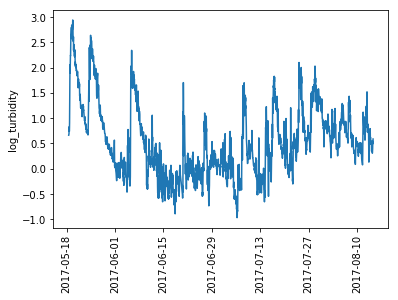

In [9]:
plot_water_quality(water_df[water_df.beach_name=='Ohio Street Beach'], 'turbidity', years = 2017)

In order to monitor swimming safety, the city also tests for E.coli from all 27 beach locations. The E.coli lab data is available here: https://data.cityofchicago.org/Parks-Recreation/Beach-Lab-Data/2ivx-z93u
<br>Let's take a look at the lab data.

In [25]:
lab_url = "https://data.cityofchicago.org/resource/awhh-mb2r.json?$limit=50000"
lab_df = request_data(lab_url)
# some dates show the year as 0016, fix that first
def fix_date(date_str):
    if type(date_str)==str:
        return date_str.replace('0016','2016')
lab_df.culture_sample_1_timestamp = pd.to_datetime(lab_df.culture_sample_1_timestamp.apply(fix_date))
lab_df.dna_sample_timestamp = pd.to_datetime(lab_df.dna_sample_timestamp)
lab_df.columns

Index(['beach', 'culture_reading_mean', 'culture_sample_1_reading',
       'culture_sample_1_timestamp', 'culture_sample_2_reading',
       'culture_sample_2_timestamp', 'culture_sample_interval',
       'culture_test_id', 'dna_reading_mean', 'dna_sample_1_reading',
       'dna_sample_2_reading', 'dna_sample_timestamp', 'dna_test_id',
       'latitude', 'location', 'longitude'],
      dtype='object')

This dataset contains readings from two E.coli testing techniques. From 2006-2016 they were using culture based testing, a slower technique which takes 18-24hrs.  Since 2015 they gradually switched to DNA testing, which only takes a few hours. All beaches had culture reading untill 2016. In 2017 the tests switched completely to DNA testing. 
<br> In the data set there are 675 samples that were tested by both techniques. We can use those data to see whether the two techniques are consistent with each other.

correlation: r=0.649365661046; p=4.41649895911e-82


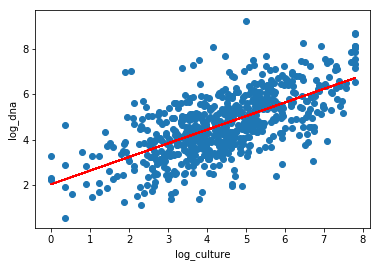

In [28]:
# dataset with both culture and dna
culture_dna = lab_df.dropna(subset=['dna_reading_mean','culture_reading_mean'])
culture_reading = np.log(culture_dna.culture_reading_mean.astype(float))
dna_reading = np.log(culture_dna.dna_reading_mean.astype(float))
(r,p) = scipy.stats.pearsonr(culture_reading, dna_reading)
print('correlation: r='+str(r)+'; p='+str(p))
X = culture_reading.values.reshape(-1,1)
y = dna_reading.values.reshape(-1,1)
regr = sklearn.linear_model.LinearRegression()
regr.fit(X,y)
y_fit = regr.predict(X)
plt.scatter(X,y)
plt.plot(X, y_fit,'r')
plt.xlabel('log_culture')
plt.ylabel('log_dna')
plt.show()

Good. They are correlated. Later when we want to forcast future Ecoli level, we could consider transforming historical culture data into dna data for more training points. For now we will focus on the lab data in 2017.
<br>Let's rank the beaches by average readings this year:

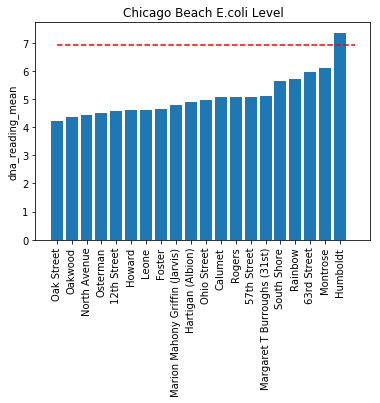

In [30]:
dna = lab_df[['beach','dna_reading_mean','dna_sample_timestamp']].dropna(subset=['dna_reading_mean'])
dna.index = pd.to_datetime(dna.dna_sample_timestamp)
dna = dna.sort_index()
dna.dna_reading_mean = dna.dna_reading_mean.astype(float).apply(log_transform)
def barplot(dataseries, threshold):
    # plot ecoli level at each beach, from lowest to highest
    dataseries = dataseries.sort_values()
    plt.bar(range(len(dataseries)),dataseries)
    plt.plot([0, len(dataseries)],[threshold, threshold],'r--')
    plt.xticks(range(len(dataseries)),dataseries.index,rotation=90)
    plt.ylabel(dataseries.name)
    plt.title('Chicago Beach E.coli Level')
    plt.show()

barplot(dna[dna.index.year==2017].groupby('beach')['dna_reading_mean'].mean(),np.log(1000))

The red dash line is the threshold above which it is not safe to swim in the water. 
<br>If you just want to see the result from today or the most recent day:

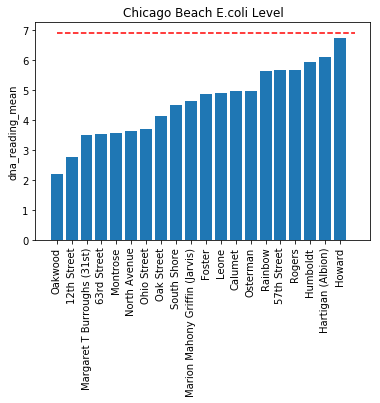

In [31]:
barplot(dna[dna.index.year==2017].groupby('beach')['dna_reading_mean'].last(),np.log(1000))

Let's take a look at North Avenue beach, as it will be populated during the Chicago Air and Water Show every summer:

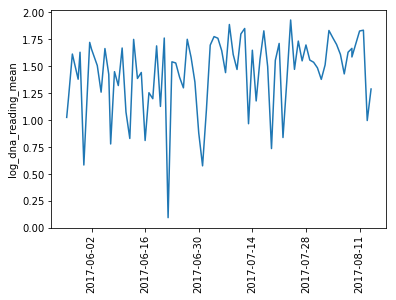

In [32]:
plot_water_quality(dna[dna.beach=='North Avenue'],'dna_reading_mean',years = 2017)

We can try out the Facebook Prophet to forecast the E.coli level at North Avenue beach in the future 10 days:

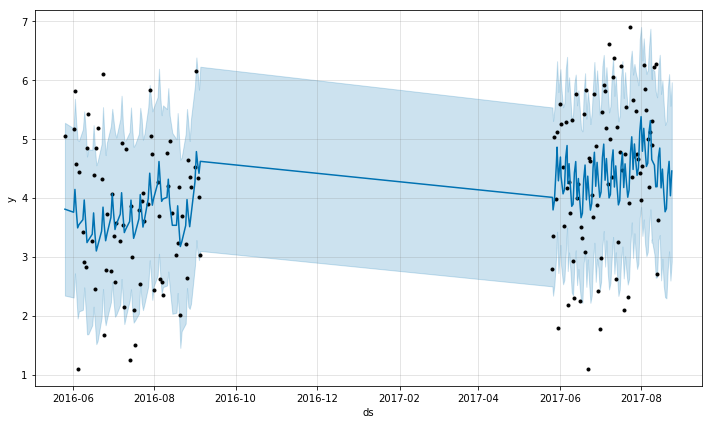

In [34]:
df = pd.DataFrame()
df['ds'] = dna.dna_sample_timestamp[dna.beach=='North Avenue']
df['y'] = dna.dna_reading_mean[dna.beach=='North Avenue']
m = Prophet(yearly_seasonality=True)
m.fit(df)
future = m.make_future_dataframe(periods=10)
forecast = m.predict(future)
m.plot(forecast)

For future direction, we can incorporate the hourly water quality data, the weather data, and historical culture testing data for multi-feature regression to improve our forecast. 

,ds,y
measurement_timestamp,,
2013-09-03 03:00:00,2013-09-03 03:00:00,1.603420
2014-06-05 12:00:00,2014-06-05 12:00:00,0.470004
2014-06-06 14:00:00,2014-06-06 14:00:00,-0.356675
2014-06-06 17:00:00,2014-06-06 17:00:00,-0.248461
2014-06-06 18:00:00,2014-06-06 18:00:00,-0.261365
